In [1]:
import random
import operator
import xlrd, math
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from gurobipy import * 
import csv

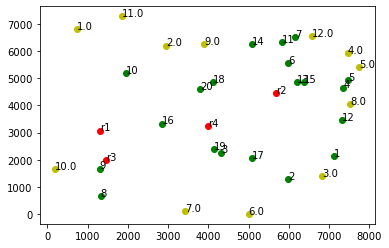

In [2]:
data = xlrd.open_workbook("orders.xlsx")
data2 = xlrd.open_workbook("couriers.xlsx")

Couriers = OrderedDict()
Orders = OrderedDict()
Rests = OrderedDict()

table  = data2.sheets()[0]
nrows = table.nrows
count = 1
for i in range(1, nrows):
    row = table.row_values(i)
    if row[0] not in Couriers.keys():
        Couriers[row[0]] = [row[1],row[2],row[3],row[4]]


table = data.sheets()[0]
nrows = table.nrows
count = 1
for i in range (1, nrows):
    row = table.row_values(i)
    if row[0] not in Orders.keys():
        Orders[count] = [row[1],row[2],row[3],row[4],row[5]]
        count += 1

table = data.sheets()[1]
nrows = table.nrows
count = 1
for i in range (1, nrows):
    row = table.row_values(i)
    if count not in Rests.keys():
        Rests[row[0]] = [row[1],row[2]]
    count += 1 
    
for i in Couriers.keys():
    plt.scatter(Couriers[i][2],Couriers[i][3], c = 'y')
    plt.text(Couriers[i][2],Couriers[i][3],i)


for i in Orders.keys():
    plt.scatter(Orders[i][0],Orders[i][1],c = 'g')
    plt.text(Orders[i][0],Orders[i][1],i)

for i in Rests.keys():
    plt.scatter(Rests[i][0], Rests[i][1], c = 'r')
    plt.text(Rests[i][0],Rests[i][1], i)
    
    

In [3]:
#得到每个order送一次的dict 加入到gurobi里面计算最早和最晚开始时间
#后期需要将这种最基本的形式与加了task的形式做比较 来表明task含量对总体时间的影响
#print(Orders)
OriginalOrders = OrderedDict()
count = 1
for i in Orders.keys():
    OriginalOrders[count] = [Orders[i][3], i]
    count += 1

print(OriginalOrders)

OrderedDict([(1, ['r1', 1]), (2, ['r1', 2]), (3, ['r1', 3]), (4, ['r1', 4]), (5, ['r1', 5]), (6, ['r2', 6]), (7, ['r2', 7]), (8, ['r2', 8]), (9, ['r2', 9]), (10, ['r2', 10]), (11, ['r3', 11]), (12, ['r3', 12]), (13, ['r3', 13]), (14, ['r3', 14]), (15, ['r3', 15]), (16, ['r4', 16]), (17, ['r4', 17]), (18, ['r4', 18]), (19, ['r4', 19]), (20, ['r4', 20])])


In [4]:
def ordered(list):
    # 遍历列表，从列表中找到起始点
    for item in list:
        # 如果列表中某个元素的第一项为1，即为起始点
        if item[0] in Rests.keys():
            # 将起始点加入排序后列表中
            ordered_list = [item]
    # 如果排序后列表长度小于列表长度，意味着排序还未完成，持续循环
    while (len(ordered_list) < len(list)):
        # 按顺序获取列表中的下一项
        ordered_list.append(get_next_element(ordered_list[-1],list))
    # 返回排序后的列表
    return ordered_list

# 获取排序后的下一项
def get_next_element(start, list):
    # 遍历列表
    for item in list:
        # 如果当前元素的第一项，等于上一个元素的第二项，那么当前元素就是下一项
        if item[0] == start[1]:
            return item

In [5]:
OriginalTasks = OrderedDict ()

traveltime = {}
xindex = {}
e = {}
f = {}
L = {}
O = {}
X = {}

for i in OriginalOrders.keys():
    #print (InitialTasks[i])
    active_arcs = []
    
    for j in range (len(OriginalOrders[i])):
        #print (j)
        #print (len(InitialTasks[5]))
        if j >= 1:
            #print (InitialTasks[i][j])
            #print (Orders[InitialTasks[i][j]][2])
            e[OriginalOrders[i][j]] = Orders[OriginalOrders[i][j]][2] + 40
            f[OriginalOrders[i][j]] = Orders[OriginalOrders[i][j]][2] + 80
            #print (e)
        for l in range (len(OriginalOrders[i])):
            xindex[OriginalOrders[i][j],OriginalOrders[i][l]] = -1
            if j == 0 and l == 0:
                traveltime[OriginalOrders[i][j],OriginalOrders[i][l]] = 0            
            if j == 0 and l >= 1:
                traveltime[OriginalOrders[i][j],OriginalOrders[i][l]] = \
                (np.sqrt ((Orders[OriginalOrders[i][l]][0] - Rests[OriginalOrders[i][j]][0]) ** 2\
                        + (Orders[OriginalOrders[i][l]][1] - Rests[OriginalOrders[i][j]][1]) ** 2)) / 350
                #print (i,traveltime[InitialTasks[i][0],InitialTasks[i][1]])
            if j >= 1 and l == 0:
                traveltime[OriginalOrders[i][j],OriginalOrders[i][l]] = \
                (np.sqrt ((Rests[OriginalOrders[i][l]][0] - Orders[OriginalOrders[i][j]][0]) ** 2\
                        + (Rests[OriginalOrders[i][l]][1] - Orders[OriginalOrders[i][j]][1]) ** 2)) / 350
            if j >= 1 and l >= 1:
                traveltime[OriginalOrders[i][j],OriginalOrders[i][l]] = \
                (np.sqrt ((Orders[OriginalOrders[i][l]][0] - Orders[OriginalOrders[i][j]][0]) ** 2\
                        + (Orders[OriginalOrders[i][l]][1] - Orders[OriginalOrders[i][j]][1]) ** 2)) / 350
            
    #print (traveltime)
    
    M = 10000
    
    ML = Model ('OTSP')
    x = ML.addVars (xindex.keys(),vtype = GRB.BINARY, name = 'x')
    u = ML.addVars (len(OriginalOrders[i])+1, vtype = GRB.CONTINUOUS, name = 'u')
    w = ML.addVars (len(OriginalOrders[i])+1, vtype = GRB.CONTINUOUS, name = 'w')
    
    ML.modelSense = GRB.MINIMIZE
    ML.setObjective  (quicksum (traveltime[a] * x[a] for a in xindex.keys()) 
                   + quicksum (w[b] for b in range (2,len(OriginalOrders[i])+1)))
    
    for b in range (2, len(OriginalOrders[i])+1):
        ML.addConstr (quicksum(x[OriginalOrders[i][a-1],OriginalOrders[i][b-1]] for a in range (1,len(OriginalOrders[i])+1) if a != b) == 1)
    
    for a in range (1, len(OriginalOrders[i])+1):
        ML.addConstr (quicksum(x[OriginalOrders[i][a-1],OriginalOrders[i][b-1]] for b in range (2,len(OriginalOrders[i])+1) if a != b) <= 1)
        
    for a in range (1, len(OriginalOrders[i])+1):
        ML.addConstr (quicksum(x[OriginalOrders[i][0],OriginalOrders[i][b-1]] for b in range (2, len(OriginalOrders[i])+1)) == 1)  
    
    for a in range (1, len(OriginalOrders[i])+1):
        for b in range (2, len(OriginalOrders[i])+1):
            if a != b:
                A = ML.addVar (lb=-GRB.INFINITY)
                ML.addConstr (u[a] +  traveltime[OriginalOrders[i][a-1],OriginalOrders[i][b-1]] + w[b]\
                             - M * (1-x[OriginalOrders[i][a-1],OriginalOrders[i][b-1]]) <= u[b])
                ML.addConstr (A == e[OriginalOrders[i][b-1]] - u[a] - traveltime[OriginalOrders[i][a-1],OriginalOrders[i][b-1]] 
                             - M * (1-x[OriginalOrders[i][a-1],OriginalOrders[i][b-1]]))
                ML.addConstr (w[b] == max_(A, 0))
                
    for a in range (1, len(OriginalOrders[i])+1):
        if a == 1:
            ML.addConstr (u[a] >= 0)
        if a >= 2:
            ML.addConstr (e[OriginalOrders[i][a-1]] <= u[a])
            ML.addConstr (u[a] <= f[OriginalOrders[i][a-1]])
            
    ML.optimize()
    L[i] = ML.objval 
    
    for a in range (1, len(OriginalOrders[i])+1):
        for b in range (1, len(OriginalOrders[i])+1):
            if a != b and x[OriginalOrders[i][a-1],OriginalOrders[i][b-1]].x > 0.99:
                A = (OriginalOrders[i][a-1],OriginalOrders[i][b-1])
                active_arcs.append (A)
    #print (active_arcs)
    
    ordered_input = ordered(active_arcs)
    ordered_path = []
    # 遍历排序后的列表
    for item in ordered_input:
    # 将列表的第一个元素加入路径
        ordered_path.append(item[0])
        # 把最后一项的第二个元素加进去
    ordered_path.append(ordered_input[-1][1])
    #print (ordered_path)
    startlocation = [Rests[ordered_path[0]][0],Rests[ordered_path[0]][1]]
    finishlocation = [Orders[ordered_path[-1]][0],Orders[ordered_path[-1]][1]]
    
    FTperorder = []
    for item in range (1,len(ordered_path)):
        FTperorder.append (Orders[ordered_path[item]][4])
    EStartime = max (FTperorder)
    
    Max = Model('Max')
    x = Max.addVars (xindex.keys(),vtype = GRB.BINARY, name = 'x')
    u = Max.addVars (len(OriginalOrders[i])+1, vtype = GRB.CONTINUOUS, name = 'u')
    w = Max.addVars (len(OriginalOrders[i])+1, vtype = GRB.CONTINUOUS, name = 'w')
    
    Max.modelSense = GRB.MAXIMIZE
    Max.setObjective (u[1])
    
    for b in range (2, len(OriginalOrders[i])+1):
        Max.addConstr (quicksum(x[OriginalOrders[i][a-1],OriginalOrders[i][b-1]] for a in range (1,len(OriginalOrders[i])+1) if a != b) == 1)
    
    for a in range (1, len(OriginalOrders[i])+1):
        Max.addConstr (quicksum(x[OriginalOrders[i][a-1],OriginalOrders[i][b-1]] for b in range (2,len(OriginalOrders[i])+1) if a != b) <= 1)
        
    for a in range (1, len(OriginalOrders[i])+1):
        Max.addConstr (quicksum(x[OriginalOrders[i][0],OriginalOrders[i][b-1]] for b in range (2, len(OriginalOrders[i])+1)) == 1)  
    
    for a in range (1, len(OriginalOrders[i])+1):
        for b in range (2, len(OriginalOrders[i])+1):
            if a != b:
                A = Max.addVar (lb=-GRB.INFINITY)
                Max.addConstr (u[a] +  traveltime[OriginalOrders[i][a-1],OriginalOrders[i][b-1]] + w[b]\
                             - M * (1-x[OriginalOrders[i][a-1],OriginalOrders[i][b-1]]) <= u[b])
                Max.addConstr (A == e[OriginalOrders[i][b-1]] - u[a] - traveltime[OriginalOrders[i][a-1],OriginalOrders[i][b-1]]
                             - M * (1-x[OriginalOrders[i][a-1],OriginalOrders[i][b-1]]))
                Max.addConstr (w[b] == max_(A, 0))
                
    for a in range (1, len(OriginalOrders[i])+1):
        if a == 1:
            Max.addConstr (u[a] >= EStartime)
        if a >= 2:
            Max.addConstr (e[OriginalOrders[i][a-1]] <= u[a])
            Max.addConstr (u[a] <= f[OriginalOrders[i][a-1]])
            
    Max.addConstr (quicksum (traveltime[a] * x[a] for a in xindex.keys()) 
                   + quicksum (w[b] for b in range (2,len(OriginalOrders[i])+1)) 
                   >= L[i])
    
    Max.optimize()
    X[i] = Max.objval       
    
    
    Min = Model('Min')
    x = Min.addVars (xindex.keys(),vtype = GRB.BINARY, name = 'x')
    u = Min.addVars (len(OriginalOrders[i])+1, vtype = GRB.CONTINUOUS, name = 'u')
    w = Min.addVars (len(OriginalOrders[i])+1, vtype = GRB.CONTINUOUS, name = 'w')
    
    Min.modelSense = GRB.MINIMIZE
    Min.setObjective (u[1])
    
    for b in range (2, len(OriginalOrders[i])+1):
        Min.addConstr (quicksum(x[OriginalOrders[i][a-1],OriginalOrders[i][b-1]] for a in range (1,len(OriginalOrders[i])+1) if a != b) == 1)
    
    for a in range (1, len(OriginalOrders[i])+1):
        Min.addConstr (quicksum(x[OriginalOrders[i][a-1],OriginalOrders[i][b-1]] for b in range (2,len(OriginalOrders[i])+1) if a != b) <= 1)
        
    for a in range (1, len(OriginalOrders[i])+1):
        Min.addConstr (quicksum(x[OriginalOrders[i][0],OriginalOrders[i][b-1]] for b in range (2, len(OriginalOrders[i])+1)) == 1)  
    
    for a in range (1, len(OriginalOrders[i])+1):
        for b in range (2, len(OriginalOrders[i])+1):
            if a != b:
                A = Min.addVar (lb=-GRB.INFINITY)
                Min.addConstr (u[a] +  traveltime[OriginalOrders[i][a-1],OriginalOrders[i][b-1]] + w[b]\
                             - M * (1-x[OriginalOrders[i][a-1],OriginalOrders[i][b-1]]) <= u[b])
                Min.addConstr (A == e[OriginalOrders[i][b-1]] - u[a] - traveltime[OriginalOrders[i][a-1],OriginalOrders[i][b-1]]
                             - M * (1-x[OriginalOrders[i][a-1],OriginalOrders[i][b-1]]))
                Min.addConstr (w[b] == max_(A, 0))
                
    for a in range (1, len(OriginalOrders[i])+1):
        if a == 1:
            Min.addConstr (u[a] >= EStartime)
        if a >= 2:
            Min.addConstr (e[OriginalOrders[i][a-1]] <= u[a])
            Min.addConstr (u[a] <= f[OriginalOrders[i][a-1]])
            
    Min.addConstr (quicksum (traveltime[a] * x[a] for a in xindex.keys()) 
                   + quicksum (w[b] for b in range (2,len(OriginalOrders[i])+1)) 
                   >= L[i])
    
    Min.optimize()
    O[i] = Min.objval        
    
    if i not in OriginalTasks.keys():
        OriginalTasks[i] = [O[i],X[i],L[i],ordered_path, startlocation,finishlocation]

Academic license - for non-commercial use only - expires 2021-07-12
Using license file /Users/hubohan/gurobi.lic
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10 rows, 11 columns and 14 nonzeros
Model fingerprint: 0x9aa8e322
Model has 1 general constraint
Variable types: 7 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 10 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 16.7828 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.678276345836e+01, best bound 1.678276345836e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 11 rows, 20 columns and 23 nonzeros
Model fingerprint: 0xde093afd
Model has 1 general constraint
Variable types: 7 continuous, 13 integer (13 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 11 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 414.178 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.141782180434e+02, best bound 4.141782180434e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 11 rows, 20 columns and 23 no

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 11 rows, 30 columns and 29 nonzeros
Model fingerprint: 0xc4d32d7e
Model has 1 general constraint
Variable types: 7 continuous, 23 integer (23 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 11 rows and 30 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 78 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.800000000000e+01, best bound 7.800000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10 rows, 33 columns and 14 nonzeros
Model fingerprint: 0x9feb75e4
Model has 1 general con

Optimize a model with 10 rows, 43 columns and 14 nonzeros
Model fingerprint: 0xd36d7e81
Model has 1 general constraint
Variable types: 7 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 10 rows and 43 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 17.5835 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.758347049547e+01, best bound 1.758347049547e+01, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 11 rows, 43 columns and 37 nonzeros
Model fingerprint: 0xa102c2dc
Model has 1 general constraint
Variable types: 7 continuous, 36 integer (36 binary)
Coefficien

Model fingerprint: 0x07926780
Model has 1 general constraint
Variable types: 7 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 11 rows and 52 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 303.99 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.039901183811e+02, best bound 3.039901183811e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 11 rows, 52 columns and 43 nonzeros
Model fingerprint: 0x6395b718
Model has 1 general constraint
Variable types: 7 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective

Model has 1 general constraint
Variable types: 7 continuous, 55 integer (55 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 11 rows and 62 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 582 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.820000000000e+02, best bound 5.820000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10 rows, 65 columns and 14 nonzeros
Model fingerprint: 0x27d0f5f4
Model has 1 general constraint
Variable types: 7 continuous, 58 integer (58 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 2e+01]
  Bounds r

In [6]:
OriginalTasks

OrderedDict([(1,
              [274.0,
               332.2172365416409,
               16.782763458358904,
               ['r1', 1],
               [1317.80337244045, 3070.49172026549],
               [7117.90926043823, 2141.91082601407]]),
             (2,
              [873.0,
               933.7542844436866,
               14.245715556313675,
               ['r1', 2],
               [1317.80337244045, 3070.49172026549],
               [5974.94671433299, 1289.70079269646]]),
             (3,
              [242.0,
               308.10610133448245,
               8.893898665516957,
               ['r1', 3],
               [1317.80337244045, 3070.49172026549],
               [4323.41278780628, 2260.40676012637]]),
             (4,
              [357.0,
               414.1782180434202,
               17.821781956580267,
               ['r1', 4],
               [1317.80337244045, 3070.49172026549],
               [7351.06670659214, 4654.05819313531]]),
             (5,
              [

In [7]:
with open('OriginalTasks.csv','w', newline = '') as csv_file:
    writer = csv.writer(csv_file)
    for key,value in OriginalTasks.items():
        writer.writerow([key,value[0],value[1],value[4][0],value[4][1],value[5][0],value[5][1],value[2]])
    csv_file.close()  

# 初始化gurobi中所需的milp的参数

In [8]:
M = 10000
m = {}
n = {}
a = {}
b = {}
t = {}
L = {}
w = {}
c = {}
#W = {}
Yindex = {} 

for k in Couriers.keys():
     for i in range (len(OriginalTasks.keys())+1):
        #print (i)
        for j in range (1, len(OriginalTasks.keys())+2):
            #print (j)
            if i != j:
                Yindex[i,j,k] = -1
                
for k in Couriers.keys():
    a[k] = Couriers[k][0]
    b[k] = Couriers[k][1]
    
    for i in range (len(OriginalTasks.keys())+1):
        if i >= 1:
            m[i] = OriginalTasks[i][0]
            n[i] = OriginalTasks[i][1]
            L[i] = OriginalTasks[i][2]
            for j in OriginalTasks.keys():
                
                if i != j:
                    #print (FinalTasks[i][5][0])
                    #print (FinalTasks[i][5][1])
                    t[i,j] = (np.sqrt ((OriginalTasks[i][5][0] - OriginalTasks[j][4][0]) ** 2\
                                     + (OriginalTasks[i][5][1] - OriginalTasks[j][4][1]) ** 2)) / 350
                    w[i,j] = -1
                    c[i,j] = -1
        if i == 0:
            for j in OriginalTasks.keys():
                t[i,j,k] = (np.sqrt ((Couriers[k][2] - OriginalTasks[j][4][0]) ** 2\
                                   + (Couriers[k][3] - OriginalTasks[j][4][1]) ** 2)) / 350
                w[i,j] = -1


# 开始gurobi计算 首先是LB Model之后是H model 

In [9]:
model = Model('Meal Delivery Parent Problem (Tasks Optimisation)')

Y = model.addVars (Yindex.keys(), vtype = GRB.BINARY, name = 'Y')
w = model.addVars (w.keys(), lb=0.0, vtype = GRB.CONTINUOUS, name = 'w')
s = model.addVars (OriginalTasks.keys(), lb=0.0, vtype = GRB.CONTINUOUS, name = 's')

model.modelSense = GRB.MINIMIZE

model.setObjective (quicksum(
                        quicksum(t[0,j,k] * Y[0,j,k] for k in Couriers.keys())  + L[j] + 
                            quicksum (w[i,j] + 
                                quicksum(t[i,j] * Y[i,j,k] for k in Couriers.keys()) for i in OriginalTasks.keys() if i != j ) 
                    for j in OriginalTasks.keys()) * 0.4 + quicksum(quicksum(10 * Y[0,j,k] for k in Couriers.keys())for j in OriginalTasks.keys()) + 20)


for i in OriginalTasks.keys():
    model.addConstr (quicksum (Y[i,j,k] for k in Couriers.keys() for j in range (1, len(OriginalTasks.keys())+2) if i != j) == 1)
    
    
for k in Couriers.keys():
    model.addConstr (quicksum (Y[0,j,k] for j in OriginalTasks.keys()) ==
                     quicksum (Y[i, len(OriginalTasks.keys())+1,k] for i in OriginalTasks.keys()))
    
for k in Couriers.keys():
    model.addConstr (quicksum (Y[0,j,k] for j in OriginalTasks.keys()) <= 1)
    
for k in Couriers.keys():
    for h in OriginalTasks.keys():
        model.addConstr (quicksum (Y[i,h,k] for i in range (len(OriginalTasks.keys())+1) if i != h) ==
                         quicksum (Y[h,j,k] for j in range (1,len(OriginalTasks.keys())+2) if j != h))
        
for i in OriginalTasks.keys():
    for j in OriginalTasks.keys():
        if i != j:
            model.addConstr (s[i] + L[i] + t[i,j] <= s[j] + M * (1 - quicksum (Y[i,j,k] for k in Couriers.keys())))
            
for i in OriginalTasks.keys():
    for j in OriginalTasks.keys():
        if i != j:
            model.addConstr (w[i,j] >= 0)
            model.addConstr (w[i,j] >= s[j] - s[i] - L[i] - t[i,j] - M * (1 - quicksum(Y[i,j,k] for k in Couriers.keys())))


for j in OriginalTasks.keys():
    model.addConstr (quicksum((a[k] + t[0,j,k]) * Y[0,j,k] for k in Couriers.keys()) <=
                     s[j] + M * (1 - quicksum(Y[0,j,k] for k in Couriers.keys())))
    
        
for i in OriginalTasks.keys():
    model.addConstr (s[i] <= quicksum (b[k] * Y[i,len(OriginalTasks.keys())+1,k] for k in Couriers.keys()) +
                     M * (1 - quicksum (Y[i,len(OriginalTasks.keys())+1,k] for k in Couriers.keys())))                      
    
for i in OriginalTasks.keys():
    model.addConstr (s[i] >= m[i])
    model.addConstr (s[i] <= n[i]) 
    
        
model.optimize()
            
if model.status == GRB.OPTIMAL:
    print (s)
    
for i in range (len(OriginalTasks.keys())+1):
    for j in range (1,len(OriginalTasks.keys()) + 1):
        for k in Couriers.keys():
            if i != j and Y[i,j,k].x >= 0.99:
                print (i,j,k)
                #print (w[i,j])

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1504 rows, 5472 columns and 27080 nonzeros
Model fingerprint: 0x4d53cb42
Variable types: 420 continuous, 5052 integer (5052 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [4e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 946 rows and 2320 columns
Presolve time: 0.04s
Presolved: 558 rows, 3152 columns, 13068 nonzeros
Variable types: 223 continuous, 2929 integer (2928 binary)

Root relaxation: objective 1.856156e+02, 1833 iterations, 0.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  185.61564    0   55          -  185.61564      -     -    0s
H    0     0                     486.5431889  185.61564  61.9%     -    0s
H    0  

In [10]:
model = Model('Meal Delivery Parent Problem (Tasks Optimisation)')

Y = model.addVars (Yindex.keys(), vtype = GRB.BINARY, name = 'Y')
s = model.addVars (OriginalTasks.keys(), lb=0.0, vtype = GRB.CONTINUOUS, name = 's')
H = model.addVars (Couriers.keys(),lb = 0.0, vtype = GRB.CONTINUOUS, name = 'H')

model.modelSense = GRB.MINIMIZE

model.setObjective (quicksum(H[k] for k in Couriers.keys()) * 0.4 + quicksum(quicksum(10 * Y[0,j,k] for k in Couriers.keys())for j in OriginalTasks.keys())+ 20)


for i in OriginalTasks.keys():
    model.addConstr (quicksum (Y[i,j,k] for k in Couriers.keys() for j in range (1, len(OriginalTasks.keys())+2) if i != j) == 1)
    
    
for k in Couriers.keys():
    model.addConstr (quicksum (Y[0,j,k] for j in OriginalTasks.keys()) ==
                     quicksum (Y[i, len(OriginalTasks.keys())+1,k] for i in OriginalTasks.keys()))
    
for k in Couriers.keys():
    model.addConstr (quicksum (Y[0,j,k] for j in OriginalTasks.keys()) <= 1)
    
for k in Couriers.keys():
    for h in OriginalTasks.keys():
        model.addConstr (quicksum (Y[i,h,k] for i in range (len(OriginalTasks.keys())+1) if i != h) ==
                         quicksum (Y[h,j,k] for j in range (1,len(OriginalTasks.keys())+2) if j != h))
        
for i in OriginalTasks.keys():
    for j in OriginalTasks.keys():
        if i != j:
            model.addConstr (s[i] + L[i] + t[i,j] <= s[j] + M * (1 - quicksum (Y[i,j,k] for k in Couriers.keys())))
            
for k in Couriers.keys():
    for i in OriginalTasks.keys():
        for j in OriginalTasks.keys():
                model.addConstr (H[k] >= 0)
                model.addConstr (H[k] >= s[i] + L[i] - (s[j] - t[0,j,k]) -  
                                 M * (2 - Y[0,j,k]- Y[i,len(OriginalTasks.keys())+1,k]))
                


for j in OriginalTasks.keys():
    model.addConstr (quicksum((a[k] + t[0,j,k]) * Y[0,j,k] for k in Couriers.keys()) <=
                     s[j] + M * (1 - quicksum(Y[0,j,k] for k in Couriers.keys())))
    
        
for i in OriginalTasks.keys():
    model.addConstr (s[i] <= quicksum (b[k] * Y[i,len(OriginalTasks.keys())+1,k] for k in Couriers.keys()) +
                     M * (1 - quicksum (Y[i,len(OriginalTasks.keys())+1,k] for k in Couriers.keys())))                      
    
for i in OriginalTasks.keys():
    model.addConstr (s[i] >= m[i])
    model.addConstr (s[i] <= n[i]) 
    
        
model.optimize()
            
if model.status == GRB.OPTIMAL:
    print (s)
    
for i in range (len(OriginalTasks.keys())+1):
    for j in range (1,len(OriginalTasks.keys()) + 1):
        for k in Couriers.keys():
            if i != j and Y[i,j,k].x >= 0.99:
                print (i,j,k)
                #print (w[i,j])

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10344 rows, 5084 columns and 49320 nonzeros
Model fingerprint: 0x8cc6ced8
Variable types: 32 continuous, 5052 integer (5052 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [4e-01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Presolve removed 7017 rows and 2124 columns
Presolve time: 0.05s
Presolved: 3327 rows, 2960 columns, 24117 nonzeros
Variable types: 31 continuous, 2929 integer (2928 binary)

Root relaxation: objective 3.000000e+01, 1118 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   30.00000    0   43          -   30.00000      -     -    0s
H    0     0                     940.5836225   30.00000  96.8%     -    0s
     0 

 109810 61632  102.17382   74   68  230.51605   50.70552  78.0%   122  295s
 113564 64142  111.03879   80   72  230.51605   50.86888  77.9%   123  301s
 115663 65760   60.30912  107   87  230.51605   51.13892  77.8%   124  306s
 117958 67956   97.16682   73   53  230.51605   51.42620  77.7%   125  311s
 119954 69660  177.14344  124   54  230.51605   51.57895  77.6%   125  315s
 123111 71689  213.80775   96   54  230.51605   51.83598  77.5%   125  321s
 125444 73314  195.77823  139   35  230.51605   52.04138  77.4%   126  325s
 128471 75522  154.14172  116   62  230.51605   52.31753  77.3%   126  331s
 130472 76860     cutoff  125       230.51605   52.38679  77.3%   126  336s
 132364 78081  115.68787   96   49  230.51605   52.64270  77.2%   127  341s
 134668 80083  204.43877  123   47  230.51605   53.09537  77.0%   128  346s
 136719 81526  206.79823  175   41  230.51605   53.16259  76.9%   128  350s
 139134 83357  193.26685  132   32  230.51605   53.28493  76.9%   128  356s
 141037 8481

 329987 228403  159.83970   65   48  230.51595   58.92776  74.4%   145  810s
 333530 230284  205.86493  119   49  230.51595   58.95300  74.4%   145  816s
 334680 231100   86.71271   61   57  230.51595   59.11107  74.4%   145  820s
 335981 232373  180.66210  116   42  230.51595   59.12138  74.4%   145  825s
 338847 234597  175.04158   70   52  230.51595   59.16036  74.3%   145  831s
 340633 235527  106.56024  116   54  230.51595   59.19689  74.3%   145  836s
 342079 236509  193.73549  113   37  230.51595   59.20555  74.3%   146  840s
 344205 238137  144.36960  114   34  230.51595   59.20555  74.3%   146  845s
 346696 240003  178.89641   76   45  230.51595   59.21037  74.3%   146  851s
 348859 241676  136.75033  136   35  230.51595   59.21037  74.3%   146  855s
 351327 243474   89.25103   48   47  230.51595   59.21483  74.3%   146  861s
 353508 245125  140.86147   65   56  230.51595   59.24572  74.3%   147  866s
 354938 246690  121.20501   60   75  230.51595   59.28068  74.3%   147  870s

 565775 404670   66.85280   46   65  230.51595   62.61355  72.8%   150 1346s
 567901 406202  164.54077  102   37  230.51595   62.65360  72.8%   150 1351s
 570020 407549  120.14668   90   52  230.51595   62.69968  72.8%   150 1356s
 571849 408573  189.43722   74   35  230.51595   62.75641  72.8%   150 1361s
 573583 409866  133.64625  118   67  230.51595   62.78310  72.8%   150 1365s
 575823 411993  196.81384  155   28  230.51595   62.82350  72.7%   150 1371s
 577648 412980   92.46603   90   56  230.51595   62.85816  72.7%   150 1375s
 580500 415364  116.63761   31   47  230.51595   62.87757  72.7%   150 1381s
 583107 417172  142.22408   55   37  230.51595   62.87757  72.7%   150 1385s
 586283 419460  150.50004  115   43  230.51595   62.87757  72.7%   150 1390s
 588801 421148  183.86402   72   34  230.51595   62.89187  72.7%   150 1395s
 591797 423440     cutoff  108       230.51595   62.99574  72.7%   150 1400s
 594490 425597   81.53648   90   58  230.51595   63.02203  72.7%   150 1406s

 803100 581514   65.62012   57   81  230.51595   65.57726  71.6%   151 1880s
 804788 582925  149.48179  155   35  230.51595   65.60167  71.5%   151 1885s
 807420 584503   77.26427   43   89  230.51595   65.62780  71.5%   151 1890s
 808901 585658 infeasible  113       230.51595   65.64536  71.5%   151 1895s
 810948 587337  131.53285  118   47  230.51595   65.66421  71.5%   151 1901s
 812847 588547  187.42520  100   28  230.51595   65.67739  71.5%   151 1905s
 814885 590135  183.68880  101   25  230.51595   65.70076  71.5%   151 1911s
 816535 591348  141.25548   75   32  230.51595   65.70076  71.5%   151 1915s
 819058 593661   81.01597   77   44  230.51595   65.71543  71.5%   151 1921s
 820976 595100  172.95577   53   48  230.51595   65.71543  71.5%   151 1926s
 823257 596318  208.20337  103   24  230.51595   65.73396  71.5%   151 1931s
 824911 597585  128.56502  114   42  230.51595   65.74945  71.5%   151 1935s
 826438 598806   87.03067  123   63  230.51595   65.77176  71.5%   151 1940s

 1046742 763963   83.59165   94   78  230.51595   67.37457  70.8%   144 2416s
 1049341 765863   85.33721   51   41  230.51595   67.39575  70.8%   144 2421s
 1052144 766987 infeasible  123       230.51595   67.39838  70.8%   143 2426s
 1054447 768651   74.98858   90   51  230.51595   67.41214  70.8%   143 2430s
 1056701 770823  196.59028  103   41  230.51595   67.42557  70.8%   143 2436s
 1058585 772395  213.67700  123   41  230.51595   67.44585  70.7%   143 2440s
 1061244 773849 infeasible   63       230.51595   67.47804  70.7%   143 2445s
 1063299 775509  143.82006  141   37  230.51595   67.48400  70.7%   143 2450s
 1067149 777944  113.41550   84   71  230.51595   67.50720  70.7%   143 2457s
 1068528 779597  139.42580  113   43  230.51595   67.52065  70.7%   143 2461s
 1070895 781463  107.69005   78   64  230.51595   67.53820  70.7%   143 2465s
 1073237 783338  167.37750  149   28  230.51595   67.54796  70.7%   143 2471s
 1076150 785412  227.63722  107   26  230.51595   67.54796  70.7

 1299025 949689  167.04815   43   38  230.51595   68.77031  70.2%   137 2946s
 1300968 951694  169.67520  134   40  230.51595   68.77520  70.2%   137 2951s
 1302756 952744     cutoff   62       230.51595   68.79270  70.2%   137 2955s
 1305224 954812  152.32203   81   47  230.51595   68.80505  70.2%   137 2960s
 1308432 957696  164.39669   64   54  230.51595   68.82939  70.1%   137 2966s
 1311290 959362  174.87548  102   30  230.51595   68.84539  70.1%   137 2971s
 1313884 961397  195.54431  145   23  230.51595   68.86726  70.1%   137 2976s
 1316051 963209 infeasible   97       230.51595   68.88702  70.1%   137 2981s
 1318597 964630  216.82751   80   29  230.51595   68.91510  70.1%   136 2986s
 1320078 965891  193.59411  126   24  230.51595   68.91887  70.1%   136 2990s
 1322343 967355  218.61794   70   44  230.51595   68.91887  70.1%   136 2995s
 1324382 968999  185.23262  159   31  230.51595   68.93295  70.1%   136 3000s
 1326800 970721  175.50637  108   42  230.51595   68.93659  70.1

 1529589 1117593 infeasible  106       230.51595   69.24572  70.0%   137 3470s
 1531540 1119563   93.79024  103   58  230.51595   69.24572  70.0%   137 3476s
 1533516 1120713  216.76901  164   60  230.51595   69.24572  70.0%   137 3481s
 1535072 1121897 infeasible  114       230.51595   69.24572  70.0%   137 3485s
 1538071 1123948  223.12189  125   36  230.51595   69.24572  70.0%   137 3491s
 1539757 1125291  214.32725  155   35  230.51595   69.24572  70.0%   137 3495s
 1542091 1126780  215.46818  165   52  230.51595   69.25956  70.0%   137 3501s
 1544582 1128476   83.06646   58   60  230.51595   69.27293  69.9%   137 3506s
 1545742 1129582  196.65707  130   38  230.51595   69.28608  69.9%   137 3510s
 1548065 1131001  138.20834   64   38  230.51595   69.30289  69.9%   137 3516s
 1549722 1132765  162.63077  123   24  230.51595   69.31874  69.9%   137 3520s
 1552607 1134402   93.09640   61   63  230.51595   69.32215  69.9%   137 3525s
 1554617 1136070   79.32298   80   66  230.51595   6